# Speeches
xxx

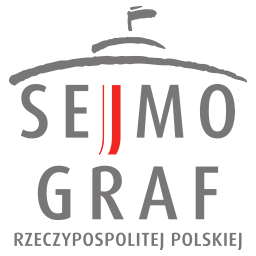


# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/SEJMograf /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/SEJMograf': File exists
/content/gdrive/My Drive/Colab Notebooks/SEJMograf


## Libraries & functions
Let's now install missing libraries and import the necessary libraries and functions we're gonna use in this notebook.

- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `plotly` - visualization

In [3]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import timeit
from bs4 import BeautifulSoup
import regex as re
import requests

# Load data

In [4]:
df = pd.read_csv('df_clean.csv', index_col=0)
df.head()

,first_name,middle_name,last_name,gender,profile_url,picture,election_date,election_list,election_constituency,election_votes,oath_date,sejm_prl_term_IX,sejm_prl_term_X,sejm_term_I,sejm_term_II,sejm_term_III,sejm_term_IV,sejm_term_V,sejm_term_VI,sejm_term_VII,sejm_term_VIII,senat_term_IX,senat_term_X,senat_term_I,senat_term_II,senat_term_III,senat_term_IV,senat_term_V,senat_term_VI,senat_term_VII,senat_term_VIII,sejm_term_IX,club,birth_date,birth_place,education,school,title,graduation_year,occupation,...,coworker_33,coworker_33_function,coworker_33_info,coworker_34,coworker_34_function,coworker_34_info,coworker_35,coworker_35_function,coworker_35_info,coworker_36,coworker_36_function,coworker_36_info,coworker_37,coworker_37_function,coworker_37_info,coworker_38,coworker_38_function,coworker_38_info,asset_declarations,declaration_01,declaration_01_info,declaration_02,declaration_02_info,benefit_registers,benefit_register_01,benefit_register_01_info,benefit_register_02,benefit_register_02_info,benefit_register_03,benefit_register_03_info,benefit_register_04,benefit_register_04_info,benefit_register_05,benefit_register_05_info,benefit_register_06,benefit_register_06_info,benefit_register_07,benefit_register_07_info,benefit_register_08,benefit_register_08_info
0,Andrzej,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8A510...,2019-10-13,Prawo i Sprawiedliwość,Kraków,29686,2019-11-12,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Prawo i Sprawiedliwość,1959-01-04,Krzeszowice,wyższe,Społeczna Akademia Nauk w Łodzi,licencjat,2014.0,poseł,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/A324231DA1...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/549650FA05...,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Rafał,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8ACA6...,2019-10-13,Sojusz Lewicy Demokratycznej,Katowice,12148,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,"Koalicyjny Klub Parlamentarny Lewicy (Razem, S...",1974-05-30,Dąbrowa Górnicza,wyższe,Politechnika Śląska,NaN,1999.0,samorządowiec,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/DB5AF9B44E...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FAE4951BE...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/EF53E6700...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Piotr,NaN,Adamowicz,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/3CA57...,2019-10-13,Koalicja Obywatelska,Gdańsk,41795,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Koalicja Obywatelska - Plat...,1961-06-26,Elbląg,średnie ogólne,VI LO Gdańsk,NaN,1980.0,dziennikarz/publicysta,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FF94DFF3A...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/2F249C8E3E...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/E7FACBAC8...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Romuald,NaN,Ajchler,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/5E88F...,2019-10-13,Sojusz Lewicy Demokratycznej,Piła,14438,2019-11-12,False,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,

In [5]:
df['id'] = df['profile_url'].apply(lambda x: int(re.search(r'\d{3}', x).group(0)))

In [6]:
df.loc[df['last_name'] == 'Sterczewski']['speeches_url']

358    https://www.sejm.gov.pl/wypowiedzi.xsp?id=360&...
Name: speeches_url, dtype: object

In [7]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few seconds to complete...\n')

# initiate the containers
speeches_pages = []
speeches = []
deputy_id = 360

def extractSpeechInfo(element):
  if len(element) > 0:
    content = element.contents[0]
  else: 
    content = element.string
  
  return content
  # pos.contents[0] if len(pos)>0 else pos.string

for page_number in range(1, 100):

  # perform a http request
  url = f'https://www.sejm.gov.pl/Sejm9.nsf/wypowiedzi.xsp?page={page_number}&id={deputy_id}&symbol=WYPOWIEDZI_POSLA&type=P'
  response = requests.get(url)

  # initiate BeautifulSoup and find objects of our interest
  soup = BeautifulSoup(response.content, 'html.parser')
  rows = soup.find('table', attrs={'class': 'lista-wyp'}).find_all('tr')[1:]

  if len(rows) > 0:
    for row in rows:
      speeches.append([extractSpeechInfo(pos) for pos in row.find_all('td')])


# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('Runtime: {} seconds.'.format(int(stop-start)))


Starting. This might take a few seconds to complete...

Runtime: 14 seconds.


In [8]:
df_speeches = pd.DataFrame(
    speeches,
    columns=[
             'posiedzenie',
             'dzień',
             'data',
             'numer',
             'tytuł',
             'retransmisja'])
df_speeches.head()

,posiedzenie,dzień,data,numer,tytuł,retransmisja
0,26,1,24-02-2021,4.,[Pierwsze czytanie rządowego projektu ustawy o...,[[Poseł Franciszek Sterczewski - retransmisja ...
1,25,1,20-01-2021,5.,[Sprawozdanie Komisji Infrastruktury o: - pose...,[[Poseł Franciszek Sterczewski - retransmisja ...
2,25,2,21-01-2021,25.,"[Informacja Wiceprezesa Rady Ministrów, Minist...",[[Poseł Franciszek Sterczewski - retransmisja ...
3,23,1,15-12-2020,6.,[Przedstawiony przez Prezesa Rady Ministrów do...,[[Poseł Franciszek Sterczewski - retransmisja ...
4,23,2,16-12-2020,15.,[Sprawozdanie Komisji Sprawiedliwości i Praw C...,[[Poseł Franciszek Sterczewski - retransmisja ...


In [9]:
def extractText(url):

  # perform a http request
  response = requests.get(url)

  # initiate BeautifulSoup and find objects of our interest
  soup = BeautifulSoup(response.content, 'html.parser')
  elements = soup.find('div', attrs={'class': 'stenogram'}).find_all('p')[1:]

  # extract plain text of the speech
  text = ''.join([e.contents[0] for e in elements])
  text = re.sub('\s+', ' ', text).strip()

  return text

In [10]:
from datetime import datetime

df_speeches['posiedzenie'] = df_speeches['posiedzenie'].astype('int64')
df_speeches['dzień'] = df_speeches['dzień'].astype('int64')
df_speeches['data'] = df_speeches['data'].apply(lambda x: datetime.strptime(str(x), '%d-%m-%Y'))
df_speeches['wypowiedź_tytuł'] = df_speeches['tytuł'].apply(lambda x: x.string)
df_speeches['wypowiedź_link'] = df_speeches['tytuł'].apply(lambda x: f'https://www.sejm.gov.pl/Sejm9.nsf/{x.get("href")}')
df_speeches['wypowiedź_treść'] = df_speeches['wypowiedź_link'].apply(lambda x: extractText(x))
df_speeches['retransmisja_link'] = df_speeches['retransmisja'].apply(lambda x: f'https://www.sejm.gov.pl/Sejm9.nsf/{x.get("href")}')
df_speeches.drop(columns=['numer', 'tytuł', 'retransmisja'], inplace=True)
df_speeches

,posiedzenie,dzień,data,wypowiedź_tytuł,wypowiedź_link,retransmisja_link,wypowiedź_treść
0,26,1,2021-02-24,Pierwsze czytanie rządowego projektu ustawy o ...,https://www.sejm.gov.pl/Sejm9.nsf/wypowiedz.xs...,https://www.sejm.gov.pl/Sejm9.nsf/transmisja.x...,Szanowny Panie Marszałku! Panie Ministrze! Wys...
1,25,1,2021-01-20,Sprawozdanie Komisji Infrastruktury o: - posel...,https://www.sejm.gov.pl/Sejm9.nsf/wypowiedz.xs...,https://www.sejm.gov.pl/Sejm9.nsf/transmisja.x...,Szanowny Panie Marszałku! Panie Ministrze! Wys...
2,25,2,2021-01-21,"Informacja Wiceprezesa Rady Ministrów, Ministr...",https://www.sejm.gov.pl/Sejm9.nsf/wypowiedz.xs...,https://www.sejm.gov.pl/Sejm9.nsf/transmisja.x...,Szanowny Panie Marszałku! Nieobecny Panie Prem...
3,23,1,2020-12-15,Przedstawiony przez Prezesa Rady Ministrów dok...,https://www.sejm.gov.pl/Sejm9.nsf/wypowiedz.xs...,https://www.sejm.gov.pl/Sejm9.nsf/transmisja.x...,Dziękuję. Szanowna Pani Marszałek! Wysoka Izbo...
4,23,2,2020-12-16,Sprawozdanie Komisji Sprawiedliwości i Praw Cz...,https://www.sejm.gov.pl/Sejm9.nsf/wypowiedz.xs...,https://www.sejm.gov.pl/Sejm9.nsf/transmisja.x...,Szanowny Panie Marszałku! Wysoka Izbo! Nie mog...
5,21,1,2020-11-18,6. Informacja dla Sejmu i Senatu Rzeczypospoli...,https://www.sejm.gov.pl/Sejm9.nsf/wypowiedz.xs...,https://www.sejm.gov.pl/Sejm9.nsf/transmisja.x...,Szanowna Pani Marszałek! Wysoka Izbo! Wysłucha...
6,21,2,2020-11-19,Sprawozdanie Komisji Infrastruktury oraz Komis...,https://www.sejm.gov.pl/Sejm9.nsf/wypowiedz.xs...,https://www.sejm.gov.pl/Sejm9.nsf/transmisja.x...,Szanowny Panie Marszałku! Panie Ministrze! Wys...
7,21,2,2020-11-19,Informacja bieżąca.,https://www.sejm.gov.pl/Sejm9.nsf/wypowiedz.xs...,https://www.sejm.gov.pl/Sejm9.nsf/transmisja.x...,Szanowny Panie Marszałku! Wysoka Izbo! W ostat...
8,21,3,2020-11-27,"Sprawozdanie Komisji Edukacji, Nauki i Młodzie...",https://www.sejm.gov.pl/Sejm9.nsf/wypowiedz.xs...,https://www.sejm.gov.pl/Sejm9.nsf/transmisja.x...,Szanowny Panie Marszałku! Wysoka Izbo! Mam wie...
9,21,3,2020-11-27,Sprawozdanie Komisji Kultury i Środków Przekaz...,https://www.sejm.gov.pl/Sejm9.nsf/wypowiedz.xs...,https://www.sejm.gov.pl/Sejm9.nsf/transmisja.x...,Szanowna Pani Marszałek! Wysoka Izbo! Konstytu...


In [31]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
tokens = nltk.word_tokenize(df_speeches['wypowiedź_treść'][0])
tokens

['Szanowny',
 'Panie',
 'Marszałku',
 '!',
 'Panie',
 'Ministrze',
 '!',
 'Wysoka',
 'Izbo',
 '!',
 'Przepisy',
 'dotyczące',
 'hulajnóg',
 'elektrycznych',
 'od',
 'dawna',
 'wymagają',
 'uporządkowania',
 '.',
 'Jest',
 'to',
 'problem',
 'zwłaszcza',
 'w',
 'większych',
 'miastach',
 ',',
 'gdzie',
 'ten',
 'środek',
 'transportu',
 'stał',
 'się',
 'w',
 'ostatnich',
 'latach',
 'niezwykle',
 'popularny',
 'dzięki',
 'wypożyczalniom',
 'komercyjnym',
 '.',
 'Dotychczasowa',
 'sytuacja',
 'prawna',
 'była',
 'niejasna',
 ',',
 'wiele',
 'przepisów',
 'po',
 'prostu',
 'nie',
 'istniało',
 ',',
 'na',
 'skutek',
 'czego',
 'część',
 'sądów',
 'traktowała',
 'hulajnogi',
 'elektryczne',
 'jak',
 'motorowery',
 '.',
 'Z',
 'reguły',
 'jednak',
 'w',
 'naszych',
 'miastach',
 'hulajnogami',
 'jeździ',
 'się',
 'po',
 'chodnikach',
 'bez',
 'żadnych',
 'ograniczeń',
 '.',
 'To',
 'naraża',
 'na',
 'niebezpieczeństwo',
 'nie',
 'tylko',
 'kierujących',
 'hulajnogami',
 ',',
 'ale',
 'takż

In [29]:
from nltk.probability import FreqDist
fdist = FreqDist(tokens)
fdist.most_common(20)

[(',', 54),
 ('.', 37),
 ('nie', 14),
 ('w', 13),
 ('po', 12),
 ('się', 11),
 ('na', 10),
 ('jest', 9),
 ('rowerów', 9),
 ('a', 9),
 ('dla', 8),
 ('do', 8),
 ('że', 7),
 ('i', 7),
 ('transportu', 6),
 ('To', 6),
 ('urządzenia', 6),
 ('czy', 6),
 ('to', 5),
 ('hulajnogi', 5)]

In [33]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
print(stop_words)

{'but', 'him', 'the', 'all', 'out', 'has', 'their', "that'll", 'how', 'until', 'there', 'few', 'a', 'herself', 'll', "doesn't", 'doing', 'o', 'did', 'being', "haven't", 'they', 've', 'shouldn', 'yours', "don't", 'what', 'no', 'while', 's', 'so', 'here', "hasn't", 'do', 'any', 'to', 'were', 'those', "mustn't", 'over', 'didn', 'her', 'its', 'weren', 'mustn', 'between', 'wasn', 'yourself', 'been', 'mightn', 'again', 'own', 'hers', 'don', "wouldn't", 'which', 'you', 'in', 'whom', 'because', 'had', 'she', 'by', 'just', 'is', 'such', 'doesn', 'now', 'both', 'should', 'y', 'haven', 'under', 'on', 'who', "shouldn't", 'theirs', 'if', 'nor', 'other', 'his', 'me', 'only', 'with', 'am', 'below', "you've", 'ain', 'aren', "couldn't", 'once', 'than', 'down', "should've", 'each', "shan't", 'as', 'some', 'into', "isn't", 'too', 'yourselves', 'at', "it's", 'off', 'more', "needn't", 'this', 'needn', 'wouldn', 'was', 'above', 'are', 'them', 'up', "won't", 'when', 'itself', "hadn't", 'hadn', 'will', 'an', 

In [ ]:
# https://towardsdatascience.com/web-scraping-and-pre-processing-for-nlp-2e78810b40f1
# https://ksopyla.com/pytorch/przetwarzanie-tekstu-nlp-torchtext-pytorch/